This notebook does:
1. Checks and visualizes how the altitude is incorporated in the graph. 
2. Explores the real distance of the graph edges vs. the equivalent-flat distance computed using the flat distances and the slope of the edges. This second distance accounts for the slope-related effort of traveling uphill. 

---
Author: Jordi Grau Escolano


# 1. Load data

In [ ]:
import sys, os, pickle
from pathlib import Path
import numpy as np
import pandas as pd  # type: ignore
import geopandas as gpd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable  # type: ignore
import contextily as ctx  # type: ignore
import osmnx as ox
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import networkx as nx

import folium
from branca.colormap import LinearColormap

# Add project root to path
project_root = Path().resolve().parents[0]
sys.path.insert(0, str(project_root))

from paths import *
import src.data_loader as dl
import src.assign_to_nodes.utils.class_node_assigner as cna
import src.optimization.helper_optimization as ho

from src.assign_to_nodes.utils.load_graph import add_altitude_and_elevation_attributes
from src.optimization.helper_optimization import (
    adjust_elevation_piecewise, adjust_elevation_parkin
)

ROOT = '..'

In [2]:
def compute_shared_data(city):
    """
    Load data for a specific city and return necessary variables for GA experiments.
    
    Args:
        city (str): City name in the format "City"
        
    Returns:
        tuple: (df, G, distance_matrix, id_to_idx, idx_to_id, distance_matrix_binary, STATION_MIN_DISTANCE)
            - df: GeoDataFrame with node attributes
            - G: NetworkX graph
            - distance_matrix: All-pairs shortest path distances
            - id_to_idx: Mapping from node IDs to matrix indices
            - idx_to_id: Mapping from matrix indices to node IDs
            - distance_matrix_binary: Binary matrix indicating if nodes are beyond min distance
            - STATION_MIN_DISTANCE: Minimum allowed distance between stations
    """    
    # Set up paths for the specific city
    location = f"{city}, Spain"
    graph_path = f"{RAW_GRAPH}/"
    EPSG = 25830  # Standard EPSG for Spain
    node_assigner = cna.NodeAttributesAssigner(city, graph_path=graph_path, crs=EPSG, buffer_size=300, root=ROOT)
    G = node_assigner.G
    df = node_assigner.node_attributes
    
    
    # Load configuration for the city
    STATION_MIN_DISTANCE = 300  # Default minimum distance between stations
    
    # # Compute distance matrix and mappings
    # distance_matrix, id_to_idx, idx_to_id = ho.compute_all_pairs_shortest_paths_dijkstra(
    #     city, G, weight='weight')

    
    return df, G, STATION_MIN_DISTANCE

df, G, STATION_MIN_DISTANCE = compute_shared_data(
    'Barcelona'
)

bcn_boundary = dl.load_bcn_boundary()

	Successfully loaded graph bike_graph with protocol 5
Loading existing node attributes from ../data/processed/nodes/node_attributes.csv


# 2. Visualizations

## 2.1. Plot graph

In [ ]:
# Helper functions
def add_north_arrow(ax, size=0.05, location=(0.9, 0.15), linewidth=1, fontsize=12, color='k'):
    """
    Adds a north arrow to the given axes.
    """
    ax.annotate(
        '', 
        xy=(location[0], location[1]), 
        xytext=(location[0], location[1] - size),
        xycoords='axes fraction',
        textcoords='axes fraction',
        arrowprops=dict(facecolor=color, edgecolor=color, width=linewidth, headwidth=15, headlength=20),
        ha='center', va='center'
    )
    ax.text(location[0], location[1] - size - 0.018, 'N', transform=ax.transAxes,
            ha='center', va='center', fontsize=fontsize, fontweight='bold', color=color)
    

def add_scalebar(ax, length, location=(0.1, 0.05), linewidth=3, units='m', fontsize=14, color='k'):
    """
    Adds a scale bar to the map.
    """
    # Get axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # Calculate start and end points in data coordinates
    x_start = xlim[0] + location[0] * (xlim[1] - xlim[0])
    y_start = ylim[0] + location[1] * (ylim[1] - ylim[0])
    x_end = x_start + length
    # Draw the scale bar
    ax.plot([x_start, x_end], [y_start, y_start], color=color, linewidth=linewidth, solid_capstyle='butt')
    # Add the label
    ax.text((x_start + x_end) / 2, y_start - 0.01 * (ylim[1] - ylim[0]), f'{int(length)} {units}',
            ha='center', va='top', fontsize=fontsize, color=color, fontweight='bold')    

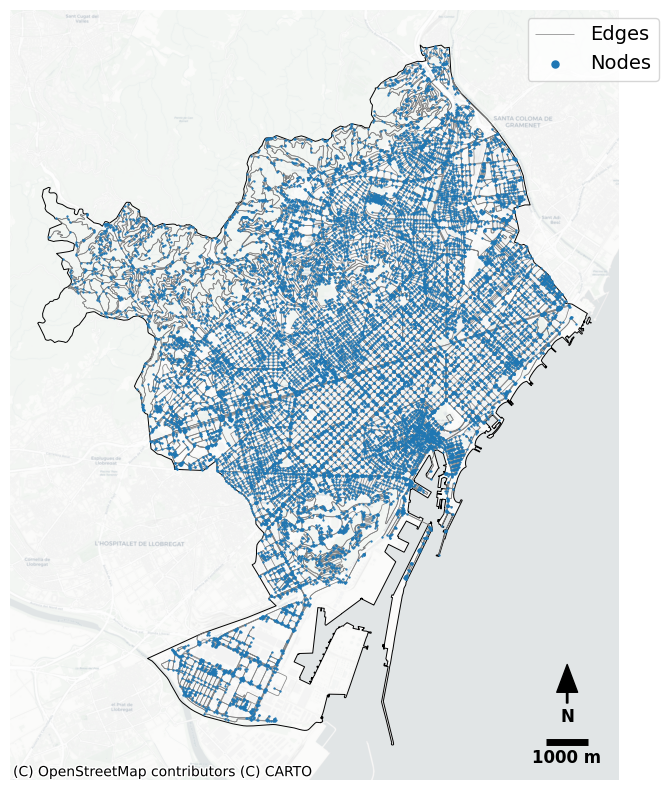

In [5]:
# Plot only the graph
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the background basemap first
bcn_boundary.boundary.plot(ax=ax, color='black', linewidth=0.7, zorder=1)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
edges_gdf.plot(ax=ax, linewidth=0.5, color='gray', label='Edges', zorder=2)
nodes_gdf.plot(ax=ax, markersize=0.4, label='Nodes', zorder=3)

# Add basemap (background) using contextily
ctx.add_basemap(ax, crs=nodes_gdf.crs, source=ctx.providers.CartoDB.Positron, alpha=0.7, zoom=14, attribution_size=10)
ax.axis('off')

fontsize = 12
# Place both on the bottom right, with the north arrow above the scalebar
add_north_arrow(ax, size=0.05, location=(0.915, 0.15), linewidth=1, fontsize=fontsize)
add_scalebar(ax, length=1000, location=(0.88, 0.05), linewidth=5, units='m', fontsize=fontsize, color='k')

plot_file = f"{ROOT}/{VISUALIZATIONS}/bike_graph.png"
ax.legend(markerscale=8, fontsize=14, loc='upper left', bbox_to_anchor=(0.85, 0.99), borderaxespad=0.)
plt.tight_layout()
# fig.savefig(plot_file, dpi=400)
plt.show()

## 2.2. Plot graph with elevation

In [9]:
# Load graph with elevation
file_name = f'{ROOT}/{RAW_GRAPH}/bike_graph_elevation.pickle'

if not os.path.exists(file_name):
    print(f"Adding altitude and elevation attributes to graph")
    G = add_altitude_and_elevation_attributes(G, ROOT)

    for u, v, key, data in G.edges(data=True, keys=True):
        distance = float(data['weight'])
        elevation = data.get('elevation', 0)
        G.edges[u, v, key][f"weight_piecewise"] = adjust_elevation_piecewise(distance, elevation)
        G.edges[u, v, key][f"weight_parkin_no_clamp"] = adjust_elevation_parkin(distance, elevation, clamp_up=False)
        G.edges[u, v, key][f"weight_parkin"] = adjust_elevation_parkin(distance, elevation)

    # Save graph with pickle
    with open(file_name, 'wb') as f:
        pickle.dump(G, f)

else:
    with open(file_name, 'rb') as f:
        G = pickle.load(f)

nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
edges_gdf = edges_gdf[['geometry', 'weight', 'elevation', 'weight_piecewise', 'weight_parkin']]

/tmp/ipykernel_24673/825806268.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


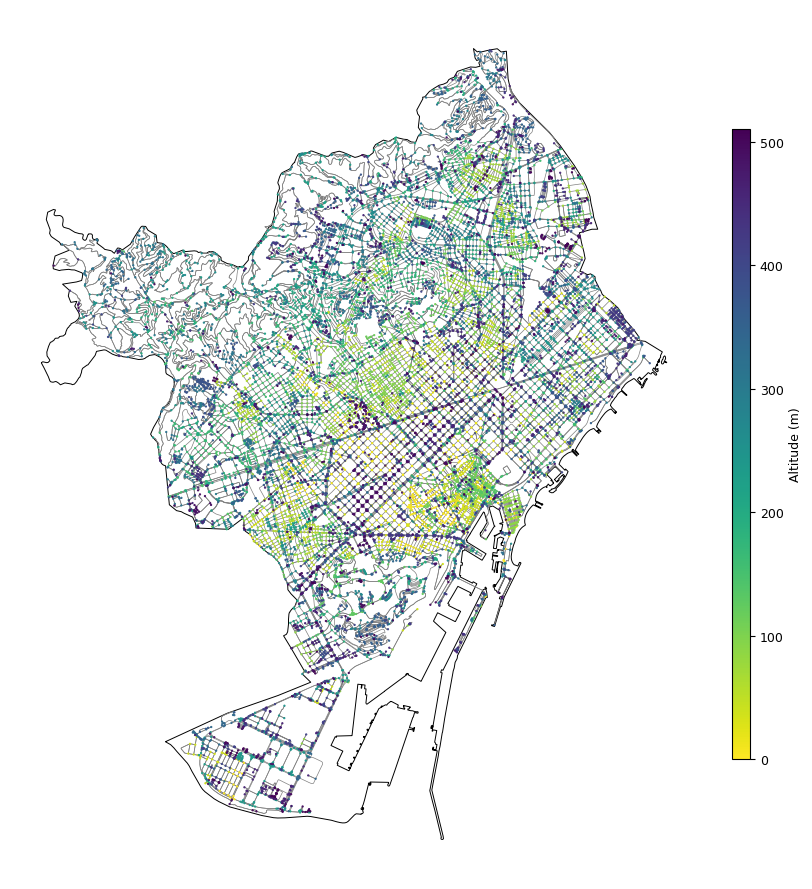

In [10]:
fig, ax = plt.subplots(figsize=(9, 9))

# Plot nodes of the graph
bcn_boundary.boundary.plot(ax=ax, color='black', linewidth=0.7)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
edges_gdf.plot(ax=ax, linewidth=0.5, color='gray', label='Edges')

# Color nodes by altitude
scatter = nodes_gdf.plot(ax=ax, markersize=0.4, label='Nodes', zorder=2, 
                        c=nodes_gdf['altitude'], legend=True, cmap='viridis_r')

# Create colorbar axis and 3 horizontal plot axes
cax = fig.add_axes((0.92, 0.15, 0.02, 0.7))  # [left, bottom, width, height]

# Create custom colormap with gray for zero values
viridis_r = plt.get_cmap('viridis_r')
colors = viridis_r(np.linspace(0, 1, 255))  # Add viridis_r colors
custom_cmap = ListedColormap(colors)
norm = Normalize(vmin=nodes_gdf['altitude'].min(), vmax=nodes_gdf['altitude'].max())

# Add colorbar
labelsize = 9
sm = ScalarMappable(norm=norm, cmap=custom_cmap)
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Altitude (m)', fontsize=labelsize)
cax.tick_params(labelsize=labelsize)

ax.axis('off')
plot_file = f"{ROOT}/{VISUALIZATIONS}/bike_graph_with_altitude.png"
plt.tight_layout()
fig.savefig(plot_file, dpi=400)

plt.show()

# 3. Analyzing the changes in the graph distances

## 3.1. Functions

In [6]:
# Tiles for interactive maps
tiles1 = "https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png"
tiles2 = 'https://{s}.basemaps.cartocdn.com/rastertiles/voyager_nolabels/{z}/{x}/{y}{r}.png'
attr1 = ('&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
    'contributors, &copy; <a href="https://cartodb.com/attributions">CartoDB</a>')
attr2 = ('&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
    'contributors &copy; <a href="https://carto.com/attributions">CARTO</a>')

In [11]:
def create_interactive_map(edges_gdf, target_var='elevation'):

    # Convert to EPSG 4326 to distorsion and match it with OSM data
    edges_gdf_crs = edges_gdf.to_crs(epsg=4326)

    # Create a base map centered on Barcelona with tile layer control
    m = folium.Map(location=[41.3851, 2.1734], zoom_start=12, control_scale=True)

    # Add different tile layers
    folium.TileLayer(tiles2, attr=attr2, name='CaroDB VoyagerNoLabels').add_to(m)
    folium.TileLayer(tiles1, attr=attr1, name='CartoDB Light NoLabels').add_to(m)

    # Add Barcelona boundary
    folium.GeoJson(bcn_boundary).add_to(m)

    # Create a colormap similar to RdBu_r
    min_elev = edges_gdf_crs[target_var].min()
    max_elev = edges_gdf_crs[target_var].max()
    colormap = LinearColormap(
        colors=['blue', 'white', 'red'],
        vmin=min_elev,
        vmax=max_elev
    )

    # Prepare fields for the interactive map tooltip
    if target_var == 'elevation':
        fields = ['elevation', 'weight']
    elif target_var == 'slope':
        fields = ['slope', 'elevation', 'weight']

    # Prepare strings for tooltips
    tooltip_strings = {
        'elevation': 'Elevation (m)',
        'slope': 'Slope (%)',
        'weight': 'Distance (m)',
        'weight_piecewise': 'Distance (m)',
        'weight_parkin': 'Distance (m)'
    }

    # Add the edges colored by slope
    folium.GeoJson(
        edges_gdf_crs.__geo_interface__,
        style_function=lambda x: {
            'color': colormap(x['properties'][target_var]),
            'weight': 3,
            'opacity': 1
        },
        tooltip=folium.GeoJsonTooltip(
                fields=fields,
                aliases=[tooltip_strings[var] for var in fields],
                localize=True,
                sticky=False
            )
    ).add_to(m)

    folium.LayerControl().add_to(m)

    # Add colormap to the map
    colormap.add_to(m)
    colormap.caption = tooltip_strings[target_var]

    return m

In [12]:
def create_static_map(edges_gdf, bcn_boundary, target_var='elevation'):
    """Create a static map showing the edges colored by elevation or slope.
    
    Args:
        edges_gdf (GeoDataFrame): GeoDataFrame containing the edges
        bcn_boundary (GeoDataFrame): GeoDataFrame containing the boundary
        target_var (str): Variable to color the edges by ('elevation' or 'slope')
    """
    # Convert to EPSG 4326 to match OSM data
    edges_gdf_crs = edges_gdf.to_crs(epsg=4326)
    bcn_boundary_crs = bcn_boundary.to_crs(epsg=4326)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot boundary
    bcn_boundary_crs.boundary.plot(ax=ax, color='black', linewidth=1)

    string_target_var = target_var.title()
    if target_var == 'slope':
        string_target_var = 'Slope (%)'
    elif target_var == 'elevation':
        string_target_var = 'Altitude difference (m)'
    
    # Plot edges colored by target variable
    edges_gdf_crs.plot(
        column=target_var,
        ax=ax,
        cmap='RdBu_r',
        legend=True,
        legend_kwds={'label': f'{string_target_var}', 'shrink': 0.5}, 
        linewidth=3
    )
    
    # Remove axes
    ax.axis('off')
    
    # Add basemap
    ctx.add_basemap(
        ax, source=ctx.providers.CartoDB.Positron, crs="epsg:4326", zoom=12)

    return fig, ax

## 3.2. Check the difference of altitude of connected nodes

Check if altitude is correctly downloaded, and if the altitude differences of each edge makes sense.

In [13]:
visualization_path = f"{ROOT}/{VISUALIZATIONS}/altitude"
Path(visualization_path).mkdir(parents=True, exist_ok=True)

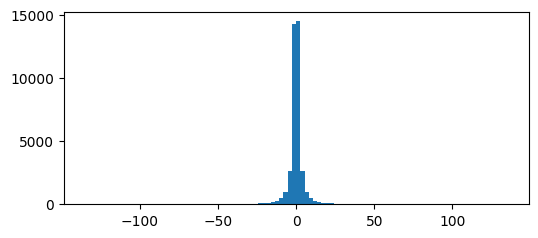

count    39116.000000
mean        -0.004788
std          6.896809
min       -135.260000
0.5%       -31.198250
1%         -21.437000
5%          -6.610000
10%         -3.630000
25%         -1.010000
50%          0.000000
75%          1.000000
90%          3.625000
95%          6.630000
99%         21.160000
99.5%       31.038500
max        135.260000
Name: elevation, dtype: float64

In [14]:
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.hist(edges_gdf['elevation'], bins=100)
fig.savefig(f"{visualization_path}/altitude_difference_histogram.png", dpi=300)
plt.show()

edges_gdf['elevation'].describe(percentiles=[0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995])

In [15]:
# create_interactive_map(edges_gdf, target_var='elevation')

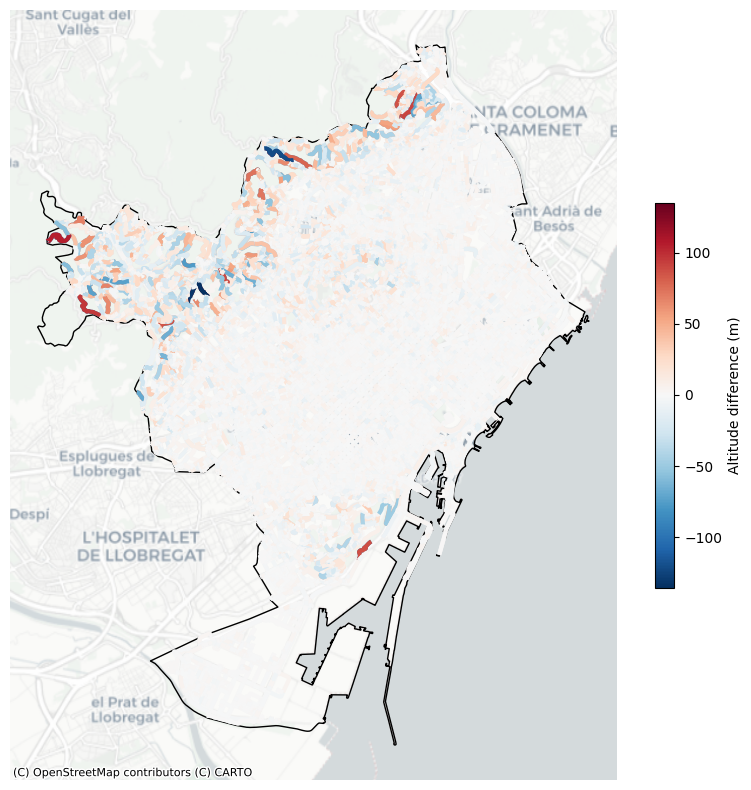

In [16]:
fig, ax = create_static_map(edges_gdf, bcn_boundary, target_var='elevation')
fig.savefig(f"{visualization_path}/altitude_difference_map.png", dpi=300)
plt.show()

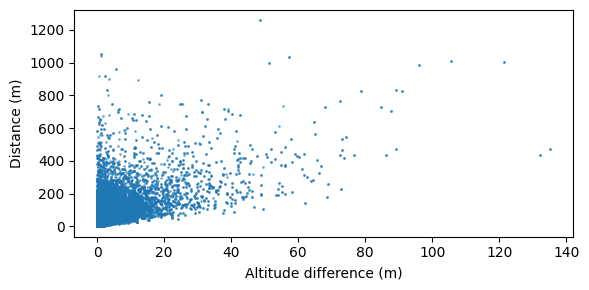

weight  elevation_abs
weight         1.000000       0.569522
elevation_abs  0.569522       1.000000

: 

In [ ]:
# Correlation between elevation and distance
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(edges_gdf['elevation'].apply(abs), edges_gdf['weight'], alpha=0.5, s=1)
ax.set_xlabel('Altitude difference (m)')
ax.set_ylabel('Distance (m)')
plt.tight_layout()
fig.savefig(f"{visualization_path}/altitude_distance_scatter.png", dpi=300)
plt.show()

# compute 
edges_gdf['elevation_abs'] = edges_gdf['elevation'].apply(abs)
edges_gdf[['weight', 'elevation_abs']].corr()

Altitude difference on the edges is correct. The biggest elevation change considering the origin and destination node of an edge is 130 m. 
This seems to be because big elevation changes are in paths that are long and/or because they are in mountainous terrain.


## 3.3. Slope

In [14]:
# Compute slope as percentage
edges_gdf['slope'] = (edges_gdf['elevation'] / edges_gdf['weight']) * 100

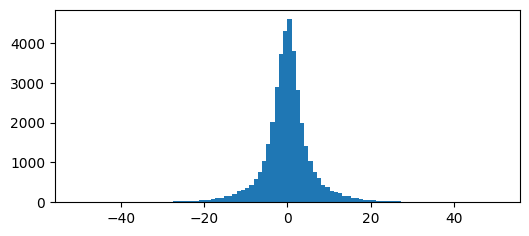

count    39116.000000
mean        -0.017543
std          6.288403
min        -50.720493
0.5%       -23.542964
1%         -18.859001
5%          -9.772317
10%         -6.180763
25%         -2.569632
50%          0.000000
75%          2.520447
90%          6.193044
95%          9.681814
99%         18.670832
99.5%       23.452660
max         50.720493
Name: slope, dtype: float64

In [15]:
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.hist(edges_gdf['slope'], bins=100)
fig.savefig(f"{visualization_path}/slope_histogram.png", dpi=300)
plt.show()

edges_gdf['slope'].describe(percentiles=[0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995])

Max slope for the OSM bike network is 50%. Too much for a bike network. Let's see the map.

In [16]:
# create_interactive_map(edges_gdf, target_var='slope')

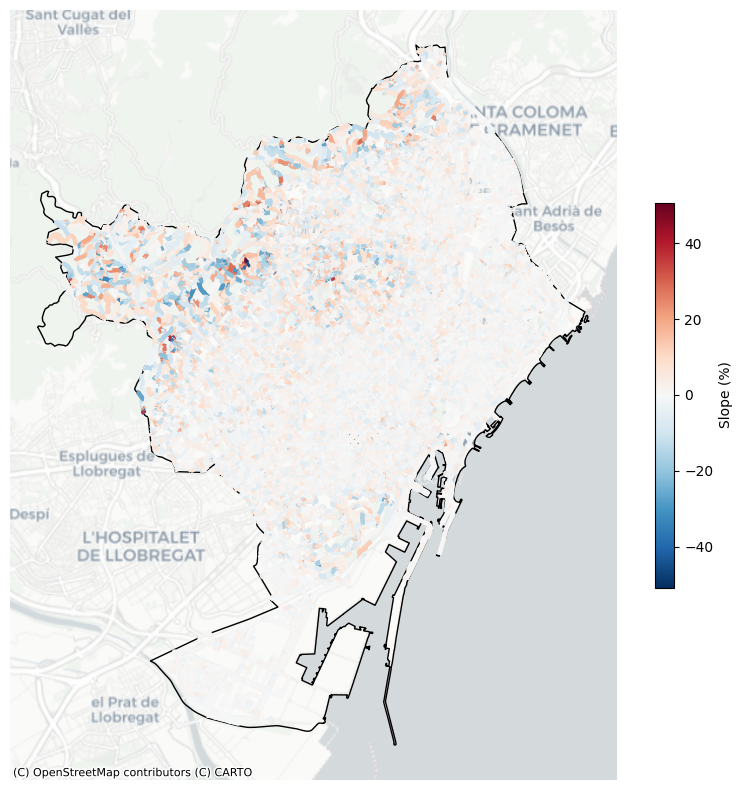

In [17]:
fig, ax = create_static_map(edges_gdf, bcn_boundary, target_var='slope')
fig.savefig(f"{visualization_path}/slope_map.png", dpi=300)
plt.show()

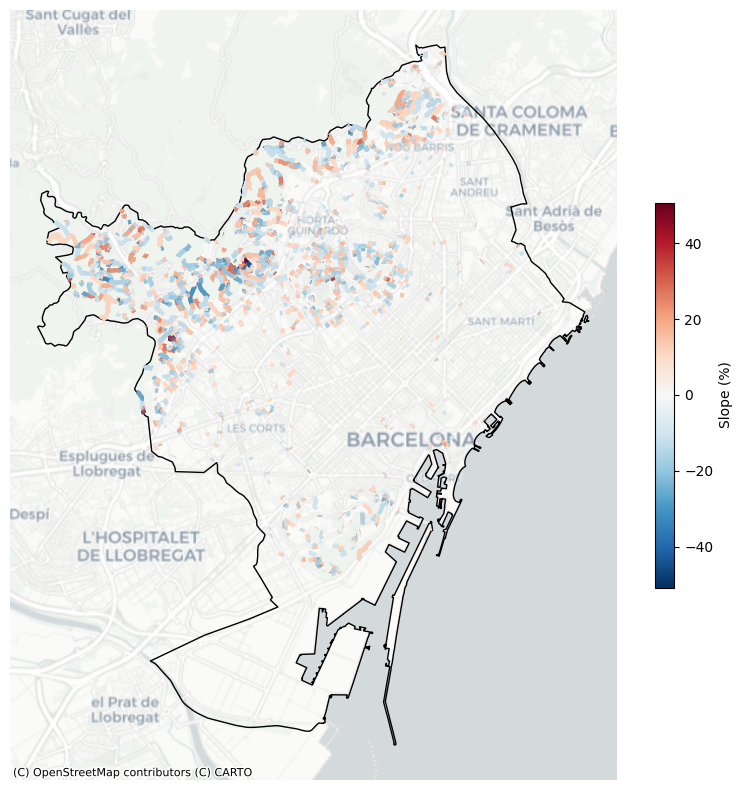

In [18]:
# Filtering out edges with slope > 10% or < -10%
edges_gdf_filt = edges_gdf[
        (edges_gdf['slope'] > 10) |
        (edges_gdf['slope'] < -10)]

fig, ax = create_static_map(edges_gdf_filt, bcn_boundary, target_var='slope')
fig.savefig(f"{visualization_path}/slope_map_filtered.png", dpi=300)
plt.show()

In [19]:
# Filtering out edges with slope > 10% or < -10%
# create_interactive_map(edges_gdf_filt, target_var='slope')

## 3.4. Explore relation between real distances and equivalent flat-distances

There are 2 types of distances:
- The real distance between the origin and destination nodes of an edge.
- The equivalent flat-distance, which is a computation of the flat distance so that it incorporates an effort-based modification based on the slope. In this notebook we explore two ways of calculating the equivalent flat-distance:
    - Using the Parkin & Rotheram (2010) formula.
    - Using the equivalent Naismith's rule for cycling with Langmuir's extension. Called Piece-wise from now on



In [20]:
edges_gdf['weight'].dropna().describe()

count    39116.000000
mean        70.931842
std         83.003612
min          0.033481
25%         16.987725
50%         48.427429
75%         97.233231
max       1257.438678
Name: weight, dtype: float64

In [21]:
edges_gdf['weight_parkin'].dropna().describe()

count    39116.000000
mean        78.808425
std         99.791635
min          0.033481
25%         18.188715
50%         51.051851
75%        105.871330
max       1891.087568
Name: weight_parkin, dtype: float64

Proportion of edges with distance: 1.0
Proportion of edges with distance_piecewise: 1.0
Proportion of edges with distance_parkin: 1.0
Proportion of edges that stayed the same piecewise: 0.1062992125984252
Proportion of edges that stayed the same parkin: 0.007490540955107885


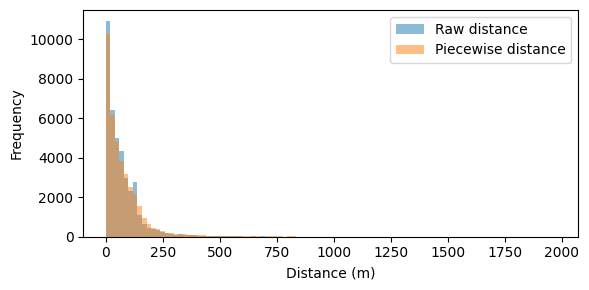

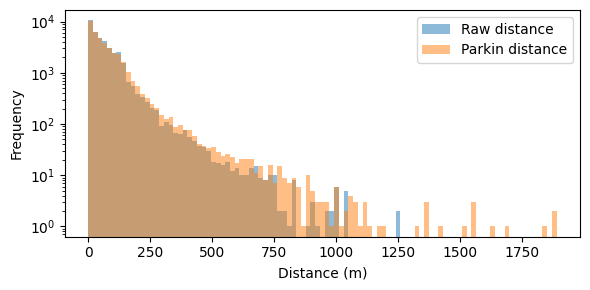


Distance: 
count    39116.000000
mean        70.931842
std         83.003612
min          0.033481
25%         16.987725
50%         48.427429
75%         97.233231
max       1257.438678
Name: weight, dtype: float64

Distance Piecewise: 
count    39116.000000
mean        82.005184
std        106.538242
min          0.033481
25%         18.677526
50%         52.193781
75%        107.563588
max       1973.510301
Name: weight_piecewise, dtype: float64

Distance Parkin: 
count    39116.000000
mean        78.808425
std         99.791635
min          0.033481
25%         18.188715
50%         51.051851
75%        105.871330
max       1891.087568
Name: weight_parkin, dtype: float64


In [22]:
print(f"Proportion of edges with distance: {edges_gdf['weight'].notna().mean()}")
print(f"Proportion of edges with distance_piecewise: {edges_gdf['weight_piecewise'].notna().mean()}")
print(f"Proportion of edges with distance_parkin: {edges_gdf['weight_parkin'].notna().mean()}")

print(f"Proportion of edges that stayed the same piecewise: {((edges_gdf['weight'] == edges_gdf['weight_piecewise']).sum() / len(edges_gdf))}")
print(f"Proportion of edges that stayed the same parkin: {((edges_gdf['weight'] == edges_gdf['weight_parkin']).sum() / len(edges_gdf))}")

# Plot raw vs piecewise distances
fig1, ax1 = plt.subplots(figsize=(6, 3))
bins = np.linspace(0, edges_gdf['weight_piecewise'].max(), 100)
ax1.hist(edges_gdf['weight'],      bins=bins, alpha=0.5, label='Raw distance')
ax1.hist(edges_gdf['weight_piecewise'], bins=bins, alpha=0.5, label='Piecewise distance')
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Frequency')
ax1.legend()
plt.tight_layout()
fig1.savefig(f"{visualization_path}/distance_equivalent_histogram_piecewise.png", dpi=300)
plt.show()

# Plot raw vs parkin distances  
fig2, ax2 = plt.subplots(figsize=(6, 3))
bins = np.linspace(0, edges_gdf['weight_parkin'].max(), 100)
ax2.hist(edges_gdf['weight'],      bins=bins, alpha=0.5, label='Raw distance')
ax2.hist(edges_gdf['weight_parkin'], bins=bins, alpha=0.5, label='Parkin distance')
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('Frequency')
ax2.set_yscale('log')
ax2.legend()
plt.tight_layout()
fig2.savefig(f"{visualization_path}/distance_equivalent_histogram_parkin.png", dpi=300)
plt.show()

print(f"\nDistance: \n{edges_gdf['weight'].describe()}")
print(f"\nDistance Piecewise: \n{edges_gdf['weight_piecewise'].describe()}")
print(f"\nDistance Parkin: \n{edges_gdf['weight_parkin'].describe()}")

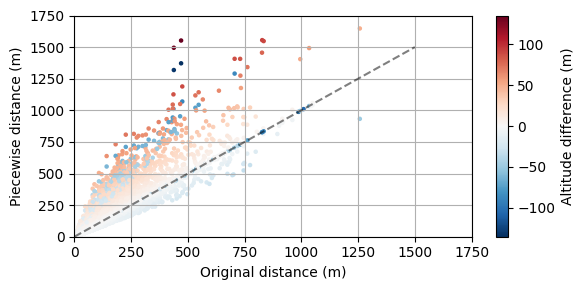

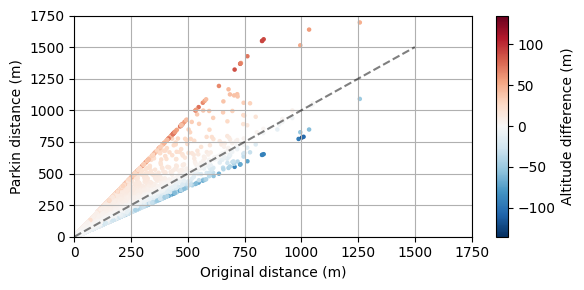

In [23]:
# Plot piecewise distances
fig1, ax1 = plt.subplots(figsize=(6, 3))
scatter1 = ax1.scatter(edges_gdf['weight'], edges_gdf['weight_piecewise'],
                      c=edges_gdf['elevation'], alpha=1, s=5,
                      cmap='RdBu_r', norm=plt.Normalize(vmin=-edges_gdf['elevation'].abs().max(),
                                                    vmax=edges_gdf['elevation'].abs().max()))

# Diagonal line
ax1.plot([0, 1500], [0, 1500], 'k--', alpha=0.5)
ax1.set_xlim(0, 1750)
ax1.set_ylim(0, 1750)

ax1.set_ylabel('Piecewise distance (m)')
ax1.set_xlabel('Original distance (m)')
ax1.grid(True)
ax1.set_xticks(np.arange(0, 1751, 250))
ax1.set_yticks(np.arange(0, 1751, 250))

# Add colorbar
plt.colorbar(scatter1, label='Altitude difference (m)')
plt.tight_layout()
fig1.savefig(f"{visualization_path}/piecewise_distance_mapping.png", dpi=300)
plt.show()

# Plot parkin distances
fig2, ax2 = plt.subplots(figsize=(6, 3))
scatter2 = ax2.scatter(edges_gdf['weight'], edges_gdf['weight_parkin'],
                      c=edges_gdf['elevation'], alpha=1, s=5,
                      cmap='RdBu_r', norm=plt.Normalize(vmin=-edges_gdf['elevation'].abs().max(),
                                                    vmax=edges_gdf['elevation'].abs().max()))

# Diagonal line
ax2.plot([0, 1500], [0, 1500], 'k--', alpha=0.5)
ax2.set_xlim(0, 1750)
ax2.set_ylim(0, 1750)

ax2.set_ylabel('Parkin distance (m)')
ax2.set_xlabel('Original distance (m)')
ax2.grid(True)
ax2.set_xticks(np.arange(0, 1751, 250))
ax2.set_yticks(np.arange(0, 1751, 250))

# Add colorbar
plt.colorbar(scatter2, label='Altitude difference (m)')
plt.tight_layout()
fig2.savefig(f"{visualization_path}/parkin_distance_mapping.png", dpi=300)
plt.show()


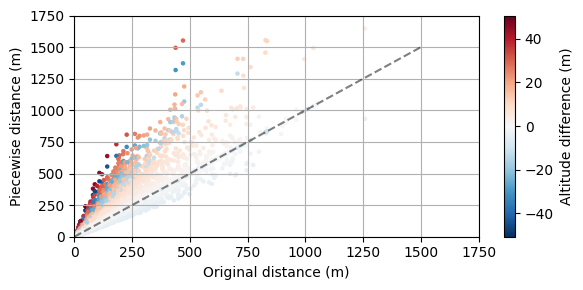

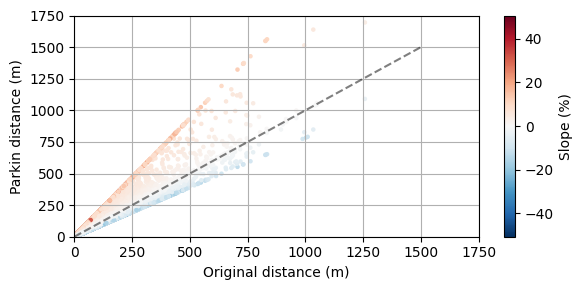

In [24]:
# Plot piecewise distances
fig1, ax1 = plt.subplots(figsize=(6, 3))
scatter1 = ax1.scatter(edges_gdf['weight'], edges_gdf['weight_piecewise'],
                      c=edges_gdf['slope'], alpha=1, s=5,
                      cmap='RdBu_r', norm=plt.Normalize(vmin=-edges_gdf['slope'].abs().max(),
                                                    vmax=edges_gdf['slope'].abs().max()))

# Diagonal line
ax1.plot([0, 1500], [0, 1500], 'k--', alpha=0.5)
ax1.set_xlim(0, 1750)
ax1.set_ylim(0, 1750)

ax1.set_ylabel('Piecewise distance (m)')
ax1.set_xlabel('Original distance (m)')
ax1.grid(True)
ax1.set_xticks(np.arange(0, 1751, 250))
ax1.set_yticks(np.arange(0, 1751, 250))

# Add colorbar
plt.colorbar(scatter1, label='Altitude difference (m)')
plt.tight_layout()
fig1.savefig(f"{visualization_path}/piecewise_distance_mapping.png", dpi=300)
plt.show()

# Plot parkin distances
fig2, ax2 = plt.subplots(figsize=(6, 3))
scatter2 = ax2.scatter(edges_gdf['weight'], edges_gdf['weight_parkin'],
                      c=edges_gdf['slope'], alpha=1, s=5,
                      cmap='RdBu_r', norm=plt.Normalize(vmin=-edges_gdf['slope'].abs().max(),
                                                    vmax=edges_gdf['slope'].abs().max()))

# Diagonal line
ax2.plot([0, 1500], [0, 1500], 'k--', alpha=0.5)
ax2.set_xlim(0, 1750)
ax2.set_ylim(0, 1750)

ax2.set_ylabel('Parkin distance (m)')
ax2.set_xlabel('Original distance (m)')
ax2.grid(True)
ax2.set_xticks(np.arange(0, 1751, 250))
ax2.set_yticks(np.arange(0, 1751, 250))

# Add colorbar
plt.colorbar(scatter2, label='Slope (%)')
plt.tight_layout()
fig2.savefig(f"{visualization_path}/parkin_distance_mapping.png", dpi=300)
plt.show()


In [25]:
# Calculate the ratio 
edges_gdf['weight_piecewise_ratio'] = edges_gdf['weight_piecewise'] / edges_gdf['weight']
edges_gdf['weight_parkin_ratio'] = edges_gdf['weight_parkin'] / edges_gdf['weight']

In [ ]:
# Visualization functions
def interactive_map_distance_ratio(edges_gdf, ratio_var='weight_piecewise_ratio'):

    edges_gdf_crs = edges_gdf.to_crs(epsg=4326)

    # Create folium map centered on Barcelona
    m = folium.Map(location=[41.3851, 2.1734], zoom_start=12, 
                   tile='cartodbdark_matter',
                   control_scale=True)

    # Add the boundary
    folium.GeoJson(bcn_boundary).add_to(m)

    # Normalize elevation for color scale
    vmin = edges_gdf_crs[ratio_var].min()
    vmax = edges_gdf_crs[ratio_var].max()
    center = 1.0

    # Split at the center value (white)
    colormap = LinearColormap(
        colors=['blue', 'white', 'red'],
        index=[vmin, center, vmax],
        vmin=vmin,
        vmax=vmax
    )

    raw_var = ratio_var.replace('_ratio', '')

    # Add the edges colored by elevation with tooltips
    folium.GeoJson(
        edges_gdf_crs.__geo_interface__,
        style_function=lambda x: {
            'color': colormap(x['properties'][ratio_var]),
            'weight': 3,
            'opacity': 1
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['elevation', 'weight', raw_var, ratio_var],
            aliases=['A (m)', 'Distance (m)', f'{raw_var} (m)', f'{ratio_var}'],
            localize=True,
            sticky=False
        )
    ).add_to(m)

    # Add colorbar
    colormap.add_to(m)

    return m


def create_static_map_distance_ratio(edges_gdf, bcn_boundary, ax=None, ratio_var='weight_piecewise_ratio'):
    """Create a static map showing the edges colored by ratio variable.
    
    Args:
        edges_gdf (GeoDataFrame): GeoDataFrame containing the edges
        bcn_boundary (GeoDataFrame): GeoDataFrame containing the boundary
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If None, creates new figure and axes.
        ratio_var (str): Variable to color the edges by
    """
    import matplotlib.colors as mcolors

    raw_var = ratio_var.replace('_ratio', '')

    # Convert to EPSG 4326 to match OSM data
    edges_gdf_crs = edges_gdf.to_crs(epsg=4326)
    bcn_boundary_crs = bcn_boundary.to_crs(epsg=4326)
    
    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig = ax.get_figure()
    
    # Plot boundary
    bcn_boundary_crs.boundary.plot(ax=ax, color='black', linewidth=1)

    # Create diverging colormap centered at 1.0
    vmin = round(edges_gdf_crs[ratio_var].min(), 2)
    vmax = round(edges_gdf_crs[ratio_var].max(), 2)
    print(vmin, vmax)
    
    # Create custom diverging colormap
    if vmax <= 1: # all values below or equal to 1
        colors = ['blue', 'white'] 
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)

    elif vmin >= 1: # all values above or equal to 1
        colors = ['white', 'red']
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
        
    else: # values span across 1
        colors = ['blue', 'white', 'red']
        center = 1.0
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
        cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
    

    string_ratio_var = {
        'weight_piecewise_ratio': 'Piecewise/original distance',
        'weight_parkin_ratio': 'Adjusted/original distance'
    }  
    
    # Plot edges colored by ratio variable
    edges_gdf_crs.plot(
        ax=ax,
        column=ratio_var,
        cmap=cmap,
        norm=norm,
        legend=True,
        legend_kwds={
            'label': f'{string_ratio_var[ratio_var]}', 
            'shrink': 0.5,
            'ticks': [vmin, round(vmin+(1-vmin)/2, 2), 1, round(1+(vmax-1)/2, 2), vmax]
        },
        linewidth=3,
        alpha=1
    )

    # Remove axes
    ax.axis('off')

    # Add basemap
    ctx.add_basemap(
        ax, source=ctx.providers.CartoDB.Positron, crs="epsg:4326", zoom=12)

    return fig, ax


In [28]:
# interactive_map_distance_ratio(edges_gdf, 'weight_piecewise_ratio')

In [29]:
# interactive_map_distance_ratio(edges_gdf, 'weight_parkin_ratio')

0.78 1.87


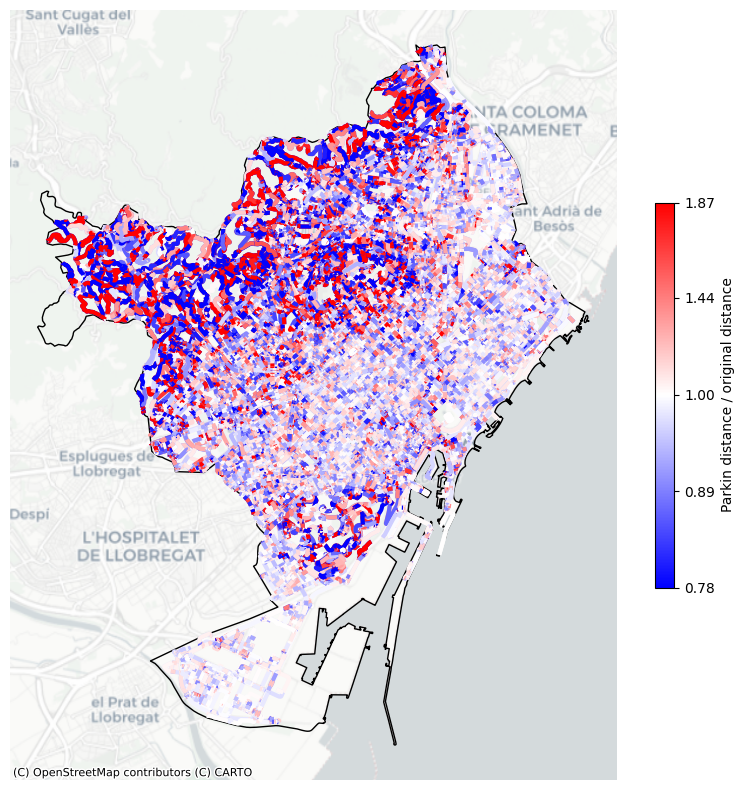

In [64]:
fig, ax = create_static_map_distance_ratio(edges_gdf, bcn_boundary, ratio_var='weight_parkin_ratio')
fig.savefig(f"{visualization_path}/parkin_distance_ratio_map.png", dpi=300)
plt.show()

1.0 1.87
0.78 1.0


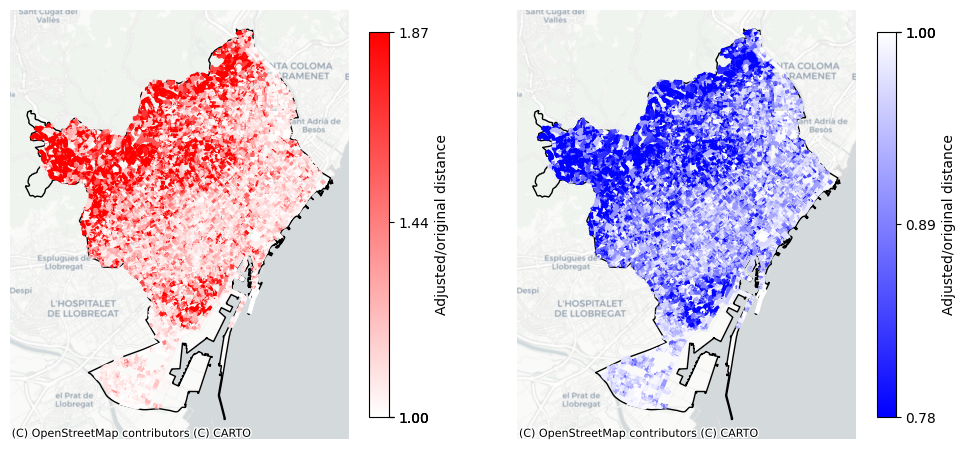

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

create_static_map_distance_ratio(
    edges_gdf[edges_gdf['weight_parkin_ratio'] >= 1], bcn_boundary, ratio_var='weight_parkin_ratio', ax=ax[0])

create_static_map_distance_ratio(
    edges_gdf[edges_gdf['weight_parkin_ratio'] <= 1], bcn_boundary, ratio_var='weight_parkin_ratio', ax=ax[1])

# fig.savefig(f"{visualization_path}/piecewise_distance_ratio_map.png", dpi=300)

plt.show()